In [57]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path

from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess

from shapely.geometry import Polygon, Point

In [43]:
def locate_ground_surface_lay(row=150):
    cross_section = ibound[:,:,0]
    lay = np.where(cross_section[:,row]==1)[0][0]
    return lay

def meter_to_col(col_meter):
    return int(np.round(col_meter/delc,0))

def meter_to_row(row_meter):
    return int(np.round(row_meter/delc,0))

def meter_to_lay(lay_meter):
    return int(np.round((top_elev-lay_meter)/layer_thickness,0))


def col_to_meter(col):
    return col*delc

def row_to_meter(row):
    return row*delc

def lay_to_meter(row):
    return 190.0-row*layer_thickness

In [44]:

def change_array_within_polygon(array, row_coords, col_coords, value):

    # Create a polygon object from the row and column coordinates
    polygon = Polygon(zip(col_coords, row_coords))

    # Create a boolean mask indicating which points fall within the polygon
    mask = np.zeros_like(array, dtype=bool)
    for row in range(array.shape[0]):
        for col in range(array.shape[1]):
            point = Point(col, row)
            if polygon.contains(point) or polygon.intersects(point):
                mask[row, col] = True

    # Set the values of the array that fall within the polygon to the new value
    array[mask] = value

    return array


# Workspace

In [45]:

# Define model workspace

myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
temp_dir = mkdtemp(prefix='_T{}_{}_'.format(myt,name))
os.makedirs(Path(temp_dir) / '_output')

#model_ws = "./modflow_model_2"
model_ws = temp_dir

def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(model_ws)

In [46]:
# Create a MODFLOW model instance
model = flopy.seawat.Seawat(modelname="example_model", model_ws=model_ws, exe_name="swtv4")


# DIS

In [47]:
# Define model dimensions
nlay = int(60*2)
nrow = int(220*2)
ncol = int(220*2)
delr = 2200/nrow  # Cell width along rows (extend 2200 / 220)
delc = 2200/ncol  # Cell width along columns (extend 2200 / 220)

# Define top elevation
top_elev = 190.0

# Define layer thickness (uniform thickness)
layer_thickness = 30.0 / nlay

perlen = 365
nper = int(1)
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))
#steady=[False,False,True]

# Create DIS package
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=delr, delc=delc,top=top_elev, 
                               botm=[top_elev - (i * layer_thickness) for i in range(1, nlay + 1)],
                               nper = nper, perlen = perlen,
                               nstp = nstp, steady = steady)



# Ibound

In [48]:
from scipy.interpolate import make_interp_spline

x = np.array([0, 100, 340, 600, 750, 850, 1100, 1350, 1450, 1530, 1650, 1750, 1850, 2050, 2200])
y_topo = np.array([190,190,187,184,184,184,183,182,179,175.5,175,173.8,173.5,172,171])#topo
y_clay = np.array([185,184,180,175,174,174,173,170,169,168.5,167.5,166.8,166.5,165,164]) #clay



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_topo)
x_smooth_topo = np.linspace(x.min(), x.max(), 30)
y_smooth_topo = spl(x_smooth_topo)

col_coords = (x_smooth_topo/delr).round(0)
col_coords_topo = list(col_coords) +[nrow,0]

row_coords = ((top_elev - y_smooth_topo)/layer_thickness).round(0)
row_coords_topo  =  list(row_coords) +[0,0]



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_clay)
x_smooth = np.linspace(x.min(), x.max(), 30)
y_smooth = spl(x_smooth)

col_coords = (x_smooth/delr).round(0)
col_coords_clay = list(col_coords) +[nrow,0]
row_coords = ((top_elev - y_smooth)/layer_thickness).round(0)
row_coords_clay  =  list(row_coords) +[nlay,nlay]



# Ibound

In [49]:
from scipy.interpolate import make_interp_spline

x = np.array([0, 100, 340, 600, 750, 850, 1100, 1350, 1450, 1530, 1650, 1750, 1850, 2050, 2200])
y_topo = np.array([190,190,187,184,184,184,183,182,179,175.5,175,173.8,173.5,172,171])#topo
y_clay = np.array([185,184,180,175,174,174,173,170,169,168.5,167.5,166.8,166.5,165,164]) #clay



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_topo)
x_smooth_topo = np.linspace(x.min(), x.max(), 30)
y_smooth_topo = spl(x_smooth_topo)

col_coords = (x_smooth_topo/delr).round(0)
col_coords_topo = list(col_coords) +[nrow,0]

row_coords = ((top_elev - y_smooth_topo)/layer_thickness).round(0)
row_coords_topo  =  list(row_coords) +[0,0]



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_clay)
x_smooth = np.linspace(x.min(), x.max(), 30)
y_smooth = spl(x_smooth)

col_coords = (x_smooth/delr).round(0)
col_coords_clay = list(col_coords) +[nrow,0]
row_coords = ((top_elev - y_smooth)/layer_thickness).round(0)
row_coords_clay  =  list(row_coords) +[nlay,nlay]



# Ibound & Strt

19 0
185.25
18 0
185.5
17 0
185.75
16 0
186.0
15 0
186.25
14 0
186.5
13 0
186.75
20 1
185.0
19 1
185.25
18 1
185.5
17 1
185.75
16 1
186.0
15 1
186.25
14 1
186.5
13 1
186.75


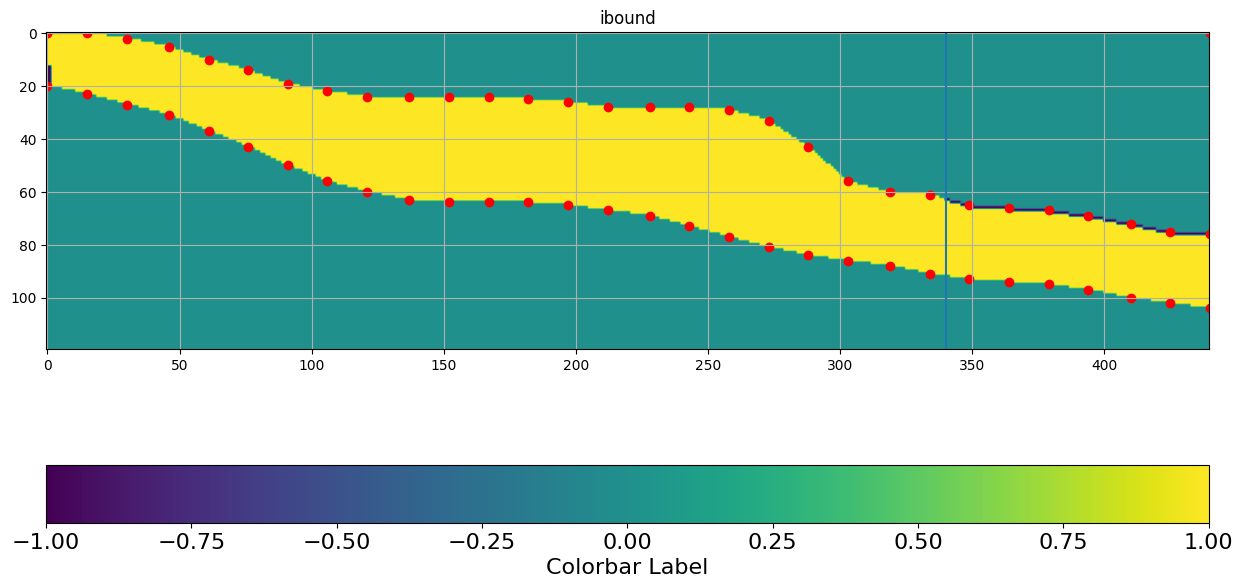

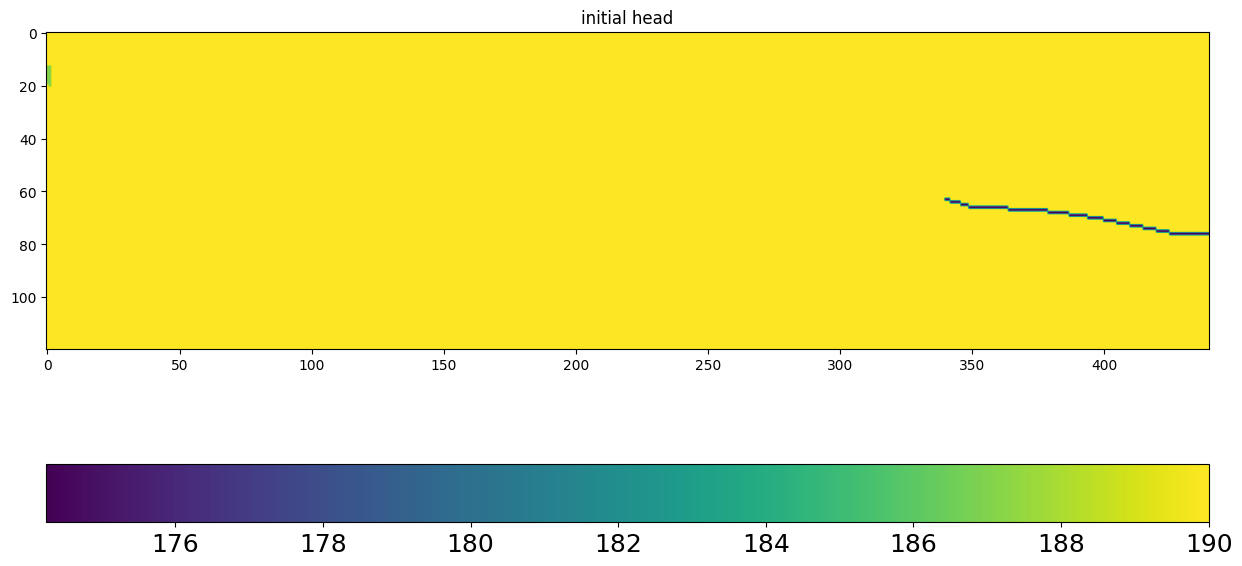

In [50]:

# Define ibound and initial conditionsa
ibound = np.ones((nlay, nrow, ncol), dtype=int)
initial_head = np.full((nlay, nrow, ncol), 190.0, dtype=float)

# Set constant head boundary conditions for the first and last rows
array = change_array_within_polygon(ibound, row_coords_topo, col_coords_topo, 0)
plt.scatter(col_coords_topo,row_coords_topo,c='r')


array = change_array_within_polygon(ibound, row_coords_clay, col_coords_clay, 0)
plt.scatter(col_coords,row_coords,c='r')




for c in range(0,2):
    i = np.where(ibound[:,c,-1]==1)[0][-1]
    head = top_elev-i*layer_thickness
    #print('head {}'.format(head))
    
    while head<187:
        ibound[i,c,:] = -1
        print(i,c)
        initial_head[i,c,:] = head+0.5
        print(head)
        initial_head[i,c,:] = 187
        head+=layer_thickness
        i-=1


lay = np.where(ibound[:,int(1700/delr),-1])[0][0]
elv = lay_to_meter(lay)
head = elv

for c in range(int(1700/delr),int(2200/delr)):
    lay = np.where(ibound[:,c,-1]==1)[0][0]
    #print(lay,lay_to_meter(lay))
    ibound[lay,c,:] = -1
    initial_head[lay,c,:] = elv

# Your existing code
im = plt.imshow(ibound[:,:,2], origin='upper', aspect=1)
plt.axvline(x=meter_to_col(1700))# shoreline
plt.gcf().set_size_inches(15,10)

# Set the y-axis tick positions and labels
#plt.yticks([0, 10,20, 30,40, 50,60], ['190m (0L)','185m (10L)', '180m (20L)','175m (30L)', '170m (40L)', '165m (50L)','160m (60L)'])

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Colorbar Label', fontsize=16)

# Display the plot
plt.title('ibound')
plt.grid()
plt.show()


fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(initial_head[:, :, 0], origin='upper')

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
plt.title('initial head')
plt.show()



# BAS LPF PCG

In [62]:

# Create BAS package
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=initial_head)

# Define hydraulic properties
horizontal_k = 6.9/3  # Horizontal hydraulic conductivity (m/day)
vertical_k = 0.1   # Vertical hydraulic conductivity (m/day)
porosity = 0.25     # Porosity

# Create LPF package (Layer Property Flow package)
lpf = flopy.modflow.ModflowLpf(model, hk=horizontal_k, vka=vertical_k, laytyp=1, ipakcb=53,ss=0.0002,sy=0.33)


pcg = flopy.modflow.ModflowPcg(model, hclose=1e-6)

# OC - Output Control Option
oc = flopy.modflow.ModflowOc(

    model,
    stress_period_data= None,
    compact=True,
)


In [63]:
#rch = flopy.modflow.ModflowRch(model = model, rech = 0.00013)

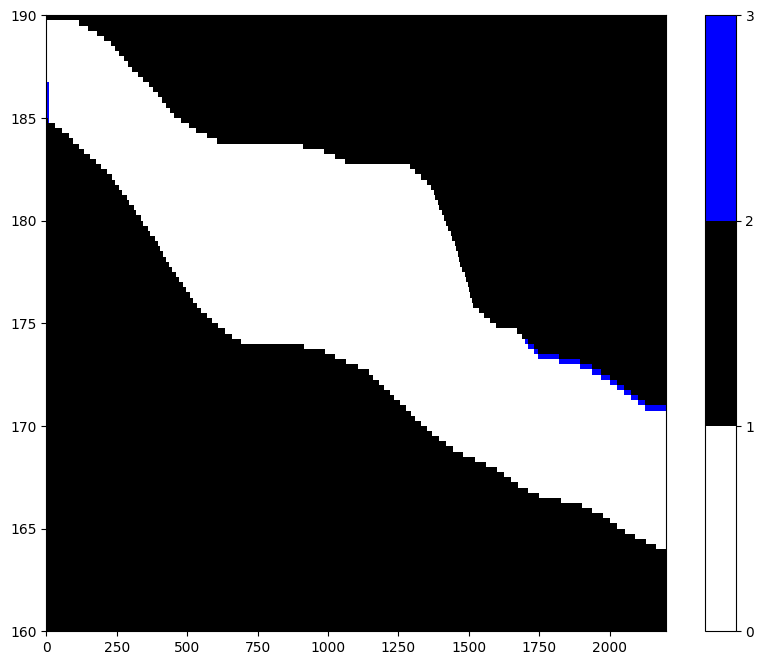

In [64]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_ibound()
plt.colorbar(patches)
plt.gcf().set_size_inches(10,8)

# Write and Run

In [65]:

# Write MODFLOW input files
model.write_input()


In [66]:
# Run the MODFLOW model
model.run_model()

FloPy is using the following executable to run the model: C:\Users\swan47\AppData\Local\flopy\bin\swtv4.EXE

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: example_model.nam                                                                                                                                                                                       
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/11 14:53:54

 Run end date and tim

(True, [])

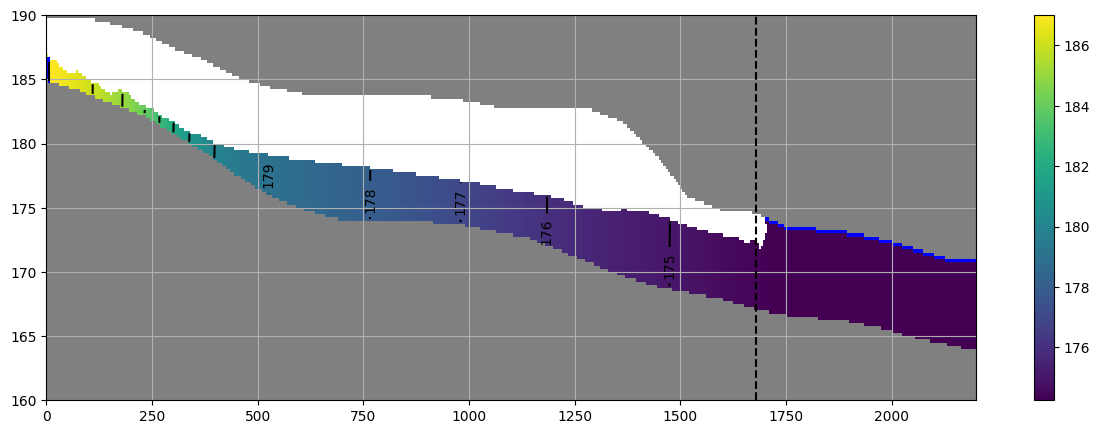

In [60]:
fig = plt.figure(figsize=(15, 5))
xsect = flopy.plot.PlotCrossSection(model=model, line={"Column": 0})

hds = flopy.utils.binaryfile.HeadFile(model_ws + '/example_model.hds')
head_data = hds.get_data(kstpkper=(0, 0)) # (time step, stress period)

ibd = model.bas6.ibound.array
masked_head_data = np.ma.masked_where(ibd== 0, head_data)

cs = xsect.plot_array(masked_head_data, cmap="viridis")
plt.colorbar(cs)

contour_levels = np.arange(164, 188, 1)
contour_set = xsect.contour_array(masked_head_data, levels=contour_levels, colors="black")
plt.clabel(contour_set, inline=True, fontsize=10, fmt="%1.0f")
plt.grid()

ibd = xsect.plot_ibound(color_noflow='grey')
#ibd.set_facecolor("red")  # set the color of the masked cells to grey

plt.axvline(x=1680, color='black', linestyle='--')

#plt.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)
# xs = drn_ys
# ys = [ lay_to_meter(locate_ground_surface_lay(meter_to_row(y))) for y in drn_ys]
# plt.scatter([x - 0.0 for x in xs],[y- 0.0 for y in ys],c='r',marker='s',s=5)

plt.show()